## Background

In the fastai course Part 1 [Lesson 6 video](https://youtu.be/AdhG64NF76E?feature=shared&t=3117) Jeremy Howard walked through the notebooks [First Steps: Road to the Top, Part 1](https://www.kaggle.com/code/jhoward/first-steps-road-to-the-top-part-1) and [Small models: Road to the Top, Part 2](https://www.kaggle.com/code/jhoward/small-models-road-to-the-top-part-2) where he builds increasingly accurate solutions to the [Paddy Doctor: Paddy Disease Classification](https://www.kaggle.com/competitions/paddy-disease-classification) Kaggle Competition. In the video, Jeremy referenced a series of walkthrough videos that he made while working through the four-notebook series for this competition. I'm excited to watch these walkthroughs to better understand how to approach a Kaggle competition from the perspective of a former #1 Kaggle grandmaster.

In this blog post series, I'll walk through the code Jeremy shared in each of the 6 Live Coding videos focused on this competition, submitting predictions to Kaggle along the way. My last two blog posts in this series reference Jeremy's [Scaling Up: Road to the Top, Part 3](https://www.kaggle.com/code/jhoward/scaling-up-road-to-the-top-part-3) notebook to improve my large model ensemble predictions. Here are the links to each of the blog posts in this series:

- [Part 1: Live Coding 8](https://vishalbakshi.github.io/blog/posts/2024-02-05-paddy-part-1/)
- [Part 2: Live Coding 9](https://vishalbakshi.github.io/blog/posts/2024-02-05-paddy-part-2/)
- [Part 3: Live Coding 10](https://vishalbakshi.github.io/blog/posts/2024-02-05-paddy-part-3/)
- [Part 4: Live Coding 11](https://vishalbakshi.github.io/blog/posts/2024-02-05-paddy-part-4/)
- Part 5: Live Coding 12 (You are here)
- [Part 6: Live Coding 13](https://vishalbakshi.github.io/blog/posts/2024-02-05-paddy-part-6/)
- [Part 7: Improving My Large Ensemble, Part 1](https://vishalbakshi.github.io/blog/posts/2024-02-05-paddy-part-7/)
- [Part 8: Improving My Large Ensemble, Part 2](https://vishalbakshi.github.io/blog/posts/2024-02-05-paddy-part-8/)


[Link to Live Coding 12 video](https://www.youtube.com/watch?v=GuCkpjXHdTc)

### Loading the Data

In [1]:
!pip install -qq timm==0.6.13
import timm
timm.__version__

'0.6.13'

In [2]:
# install fastkaggle if not available
try: import fastkaggle
except ModuleNotFoundError:
    !pip install -Uq fastkaggle

from fastkaggle import *
from fastai.vision.all import *

comp = 'paddy-disease-classification'
path = setup_comp(comp, install='fastai')

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
path.ls()

(#4) [Path('../input/paddy-disease-classification/sample_submission.csv'),Path('../input/paddy-disease-classification/train_images'),Path('../input/paddy-disease-classification/train.csv'),Path('../input/paddy-disease-classification/test_images')]

In [4]:
trn_path = path/'train_images'

### Review of [best vision models for fine-tuning](https://www.kaggle.com/code/jhoward/the-best-vision-models-for-fine-tuning)

On PETS, in the top 15, you have a bit of everything (resnetrs, resnetv2, vit, swin, resnet26d, regnet, convnext). The larger vit models only work on larger images. Pleasantly surprised to see some of the vit's didn't use much memory and they were pretty fast. resnetrs is small and fast. 

On PLANET, it doesn't look that different except it's entirely vit, swin and convnext in the top 15. vit_small_patch32_224's memory usage is amazing.

Running these models took less than 3 hours on Jeremy's three GPUs. 1200 runs. 

When to use larger images? Do everything you can on smaller images, as long as it gets you reasonable results, because you want to iterate quickly. Then, when you want the best accuracy you try bigger and bigger images and see what you can get away with--keep doing that as long as the accuracy improves. In a production environment it's similar, you make it bigger and bigger until the latency of the model is too high, and you find the right trade-off between model latency and accuracy. Generally speaking, larger images will give you more accurate results but a lot slower (you end up with a lot more pixels from 224^2 to 360^2). For initial iterating you don't need a really accurate model because you are trying to figure out what data preprocessing works best, or what architecture works best. In a business context, Jeremy would do exactly what he has done here---try a few things on small fast models on small images on a small subset of the data to find out what data preprocessing and architecture to use, and then he would look at what are the constraints in operationalizing this (how much RAM do we have, how much latency can we get away with, how expensive is it going to be) to scale it up to the point where we are getting acceptable results using acceptable resources. It wouldn't look very different at all than a Kaggle competition in terms of the modeling, but there would be a whole piece of it around user requirements, costs, and stuff like that. 

One student tried going from smaller to larger models but it resulted in lower accuracy (note: this is what essentially happened to me, except for the large ensemble with 3-times weighted vit model which matches the small ensemble's private score), is it just a fluke? No, it's not a fluke. It means you pressed the wrong buttons somehow. Re-run Jeremy's notebooks and then look at yours and see how they're different. And then figure out where you went wrong. When debugging, look at the inputs and outputs---what predictions are you making? For example are you always predicting 0? Did you run `lr.find` to see what learning rate works well? Stuff like that. 

When exporting a model, the format is pickle but the file extension is `pth` (what PyTorch uses).

### Multi-head deep learning model setup



Let's take a look at the `variety` column in `train.csv`:

In [5]:
df = pd.read_csv(path/'train.csv')

In [6]:
df

,image_id,label,variety,age
0,100330.jpg,bacterial_leaf_blight,ADT45,45
1,100365.jpg,bacterial_leaf_blight,ADT45,45
2,100382.jpg,bacterial_leaf_blight,ADT45,45
3,100632.jpg,bacterial_leaf_blight,ADT45,45
4,101918.jpg,bacterial_leaf_blight,ADT45,45
...,...,...,...,...
10402,107607.jpg,tungro,Zonal,55
10403,107811.jpg,tungro,Zonal,55
10404,108547.jpg,tungro,Zonal,55
10405,110245.jpg,tungro,Zonal,55


In [8]:
df.variety.value_counts()

variety
ADT45             6992
KarnatakaPonni     988
Ponni              657
AtchayaPonni       461
Zonal              399
AndraPonni         377
Onthanel           351
IR20               114
RR                  36
Surya               32
Name: count, dtype: int64

About 70% of the ~10k rows of data are of the "ADT45" variety. But there are ~3k rows that contain other varieties. Something that is a bit counterintuitive: when there's two different things (what kind of rice is it, what kind of disease is it) sometimes trying to get your model to predict two different things makes tham better at both. This sounds counterintuitive because you are giving it more work to do but you are also giving it more signal---things you're teaching it to look for. So maybe if it knows how to recognize different kinds of rice, it can use that information to also recognize how different kinds of rice are impacted by different diseases. No idea if this is going to be useful or not but it would be an interesting exercise to try to do that. Also a good exercise of delving into models in a way we haven't done before. This is going to be much more sophisticated than anything we've done with deep learning before. It's a really good test of how well you understand what's going on inside a neural network.

Jeremy trained a model three times to see what the error rate was, to see what kind of variation there is. A learning rate of 0.02 for 3 epochs gave consistent results. People are often into doing reproducible training where they have set the seed for their training and run the same thing everytime. I think that's normally a bad idea because I actually want to see what the natural variation is and so **if I make a change I want to know if the difference I see in the result is due to natural variation or it's actually something significant.** If the natural variation is very large, it's going to be tough to see if you actually improved things. But then if the natural variation is so large that improvements are invisible then trying to improve it seems pointless because it sounds like you haven't really found a way to stably train something. And normally that happens because the learning rate is too big. If you bump the learning rate to 0.04 you'll see the error rate go all over the place (5%, 6^, etc.). Training for more epochs at a lower learning rate will generally give you more stable results. There's a compromise because doing more epochs is slow. You could also try using a smaller subset of the data. In the end sometimes things will just be slow but most of the time Jeremy finds that you can get a compromise. 

With 6 epochs at half the learning rate (0.01) the model is more accurate (4% error rate rather than 5%).

These improvements you make on a small scale show up on a larger scale. They pretty much always will because they are the same models with more layers or wider activations. If you find some preprocessing step that works well on a convnext tiny, it's going to work also well on a convnext larg, 99.9% of the time. Most people act as if that's not true, like in academia, or most people never think to try. But intuitively, of course it's the same. Why wouldn't it be the same? It's the same model just scaled up a bit that behaves very similarly. You can argue that it's intuitive, but it might not be intuitive because everybody has told you for years that it doesn't work that way.

I'll run three trainings of the model as Jeremy has done, to get a sense of the variation in error rates for the `convnext_tiny_in22k` model:

In [5]:
dls = ImageDataLoaders.from_folder(
    trn_path, seed=42, valid_pct=0.2,
    item_tfms=Resize(480), batch_tfms=aug_transforms(size=224, min_scale=0.75))

In [6]:
arch = 'convnext_tiny_in22k'

In [11]:
learn = vision_learner(dls, arch, metrics=error_rate).to_fp16()
learn.fine_tune(3, 0.02)

epoch,train_loss,valid_loss,error_rate,time
0,1.183931,0.734716,0.228736,00:57


epoch,train_loss,valid_loss,error_rate,time
0,0.706453,0.518948,0.162422,01:04
1,0.408914,0.192417,0.058626,01:03
2,0.220568,0.127589,0.037482,01:04


In [12]:
learn = vision_learner(dls, arch, metrics=error_rate).to_fp16()
learn.fine_tune(3, 0.02)

epoch,train_loss,valid_loss,error_rate,time
0,1.156675,0.834739,0.226333,00:57


epoch,train_loss,valid_loss,error_rate,time
0,0.689531,0.731114,0.203268,01:04
1,0.420913,0.229073,0.076886,01:05
2,0.221704,0.140325,0.041807,01:06


In [13]:
learn = vision_learner(dls, arch, metrics=error_rate).to_fp16()
learn.fine_tune(3, 0.02)

epoch,train_loss,valid_loss,error_rate,time
0,1.198419,0.696659,0.214320,00:57


epoch,train_loss,valid_loss,error_rate,time
0,0.651208,0.480119,0.150889,01:04
1,0.429291,0.229344,0.069197,01:01
2,0.225388,0.136109,0.043248,01:03


The final error rates for convnext_tiny_in22k using a learning rate of 0.02 for 3 epochs were 0.037482, 0.041807, and 0.043248 (the first time I ran these three models). The largest difference in error rate between the three models was 15%. That seems not great. In the video, Jeremy's models had a difference of 3%.

Let's actually look at a model. To simplify things later on (when adding new layers to handle two categories of classification) we will remove the `to_fp16` call.

In [42]:
learn = vision_learner(dls, arch, metrics=error_rate)

In [43]:
m = learn.model

There are two things at the top of the model: 

- TimmBody (which has multiple things in it, the first being the `model`, which in turn has multiple things, the first being the `stem`, the next being `stages` and so on).
    - The body does all the hard work of looking at the pixels and trying to find features and things like that. In this case it's a convolutional neural network. At the very end of it it spits out a whole bunch of information about those pixels. 
- the head ((1): Sequential).
    - the head makes sense of what the body spits out and returns predictions. The head is pretty simple, the body is not.
 
We want to predict two things: what kind of rice it is and what disease it has. Currently the very last layer is a linear layer:

```
(8): Linear(in_features=512, out_features=10, bias=False)
```

A lineary layer is something that does a matrix product, with an input of 512 features and output of 10 features. A 512 x 10 matrix.

Let's grab the head (which is the index-1 thing in the model)

In [44]:
h = m[1]

In [45]:
h

Sequential(
  (0): AdaptiveConcatPool2d(
    (ap): AdaptiveAvgPool2d(output_size=1)
    (mp): AdaptiveMaxPool2d(output_size=1)
  )
  (1): fastai.layers.Flatten(full=False)
  (2): BatchNorm1d(1536, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Dropout(p=0.25, inplace=False)
  (4): Linear(in_features=1536, out_features=512, bias=False)
  (5): ReLU(inplace=True)
  (6): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): Dropout(p=0.5, inplace=False)
  (8): Linear(in_features=512, out_features=10, bias=False)
)

Is there a way to see the shape of the data as it flows through the model?

Yes, with `learn.summary()` (full output is too long so showing a snippet here). The `64` is because we are using a batch size of `64`. For each image we are predicting 10 probabitilies (for 10 classes of disease).

```
Sequential (Input shape: 64 x 3 x 224 x 224)
============================================================================
Layer (type)         Output Shape         Param #    Trainable 
============================================================================

...

____________________________________________________________________________
                     64 x 1536           
Flatten                                                        
BatchNorm1d                               3072       True      
Dropout                                                        
____________________________________________________________________________
                     64 x 512            
Linear                                    786432     True      
ReLU                                                           
BatchNorm1d                               1024       True      
Dropout                                                        
____________________________________________________________________________
                     64 x 10             
Linear                                    5120       True      
____________________________________________________________________________
```

Let's look at the last layer of the head:

In [46]:
ll = h[-1]

In [47]:
ll

Linear(in_features=512, out_features=10, bias=False)

We can view the parameters in the layer, which are generated lazily so we have to put it in a `list` to force it to generate them:

In [48]:
llp = list(ll.parameters())[0]

In [49]:
llp.shape

torch.Size([10, 512])

The last layer parameters (`llp`) is a matrix which is 10 x 512. We're getting 512 inputs, and when we multiply them by this matrix we get 10 outputs. 

If we removed this layer, the last layer would be taking in 1536 features and spitting out 512 features:

```
(4): Linear(in_features=1536, out_features=512, bias=False)
```

We'll delete it, and then take those 512 features and create two linear layers for them, one with 10 outputs as before (for disease classification) and one with 10 outputs for variety classification (there are 10 varieties). The final output would be 2 x 10 for each image---one with probabilities for disease classes, and one for variety classes.

Let's do the easy thing first which is to delete the layer we don't want. A PyTorch `Sequential` takes the output of each layer and passes it as the input to the next layer. If we delete the last layer, that's no problem, it just won't ever call it. PyTorch's `Sequential` has normal `list` semantics so you can delete a layer like so:

In [50]:
del(h[-1])

In [51]:
h

Sequential(
  (0): AdaptiveConcatPool2d(
    (ap): AdaptiveAvgPool2d(output_size=1)
    (mp): AdaptiveMaxPool2d(output_size=1)
  )
  (1): fastai.layers.Flatten(full=False)
  (2): BatchNorm1d(1536, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Dropout(p=0.25, inplace=False)
  (4): Linear(in_features=1536, out_features=512, bias=False)
  (5): ReLU(inplace=True)
  (6): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): Dropout(p=0.5, inplace=False)
)

We're going to create a `class` which includes this model and adds the final two layers:

In [72]:
from copy import deepcopy

In [94]:
dls = ImageDataLoaders.from_folder(
    trn_path, seed=42, valid_pct=0.2,
    item_tfms=Resize(480), batch_tfms=aug_transforms(size=224, min_scale=0.75))

learn = vision_learner(dls, arch, metrics=error_rate)
learn2 = deepcopy(learn)

In [95]:
class DiseaseAndTypeClassifier(nn.Module):
    # the constructor
    def __init__(self, m):
        super().__init__() # always call the superclass init to construct the object
        self.l1 = nn.Linear(512, 10, bias=False) # variety
        self.l2 = nn.Linear(512, 10, bias=False) # disease
        del(m[1][-1]) # delete the last layer of the model's head
        self.m = m # model
        
    def forward(self, x):
        x = self.m(x)
        x1 = self.l1(x) # variety output
        x2 = self.l2(x) # disease output
        return x1, x2

In [96]:
dtc = DiseaseAndTypeClassifier(learn2.model)
learn2.model = dtc

When calling `get_preds` even though `with_loss=False` the `Learner` is still needing to use the loss function for something. So, we'll write the new loss function. The loss function is the thing which is a number which says how good is this model. The loss function that we were using was designed on something that only returned a single tensor. And now we're returning a tuple of tensors (`x1, x2`). So that's why when it tries to call the loss function, it gets confused.

The loss function is another thing that is stored inside the `Learner`.

In [97]:
learn.loss_func

FlattenedLoss of CrossEntropyLoss()

In the initial new loss function, we'll just return the loss for the disease predictions using the current loss function. We don't have to split the `targs` yet because currently they hold just the disease targets. We're going to have to change our data loading as well to include the rice variety as well.

Why is the loss function determined from the dataset? (As seen in the `Learner` source code).

Generally speaking, what is the appropriate loss function to use as a reasonable default depends on what kind of data you have. So if you're data is a single continuous output you probably have a regression problem so you probably want mean squared error. If it's a single categorical variable you probably want cross entropy loss. If you have a mult-categorical variable you probably want log loss without softmax. And so forth. By having it come from the dataset means that you can get sensible defaults that ought to work for that dataset. That's why we generally don't have to specify what loss function to use unless we're doing something non-standard.

In [98]:
curr_loss = learn2.loss_func

In [100]:
def dtc_loss(preds, targs):
    rice_preds, dis_preds = preds
    return curr_loss(dis_preds, targs)

In [101]:
def dtc_error(preds, targs):
    rice_preds, dis_preds = preds
    return error_rate(dis_preds, targs)

In [102]:
learn2.loss_func = dtc_loss
learn2.metrics = [dtc_error]

In [103]:
learn2.loss_func

<function __main__.dtc_loss(preds, targs)>

In [104]:
learn2.metrics

(#1) [<fastai.learner.AvgMetric object at 0x78339534eb00>]

At this point we should be able to get some predictions to verify that the plumbing is working. 

In [105]:
preds, targs = learn2.get_preds(dl=learn2.dls.valid)

We've now got two sets of preditions, variety, and disease.

In [106]:
len(preds)

2

In [107]:
preds

(tensor([[ 1.4707,  1.5254, -1.5469,  ...,  3.5859, -9.7422, -7.9531],
         [ 2.8262, -0.3391, -1.0713,  ...,  3.9258, -6.7891, -5.5508],
         [ 1.2178,  0.2090, -1.3574,  ...,  2.4629, -6.9688, -6.0234],
         ...,
         [ 1.2422,  0.5278, -0.7520,  ...,  1.9199, -7.2109, -6.4258],
         [ 2.9219, -0.2183, -1.1211,  ...,  1.8584, -6.8516, -6.2461],
         [ 2.0469,  0.6406, -1.3174,  ...,  3.8027, -9.2891, -5.8086]],
        dtype=torch.float16),
 tensor([[ 2.8516, -2.9395, -3.2852,  ...,  1.3027, -1.5234, -2.8223],
         [ 3.4375, -1.3428, -3.8047,  ..., -0.9033, -0.5435, -3.0449],
         [ 4.1719, -1.0127, -2.9375,  ..., -0.5962,  0.7446, -3.3828],
         ...,
         [ 3.5781, -1.2656, -2.3008,  ..., -0.3660, -0.0957, -4.2734],
         [ 4.9727, -0.4153, -2.6562,  ...,  0.9844,  0.7559, -3.6738],
         [ 6.0703, -1.4375, -3.6797,  ..., -1.5928,  2.6211, -5.0625]],
        dtype=torch.float16))

In [108]:
rice_preds, dis_preds = preds

In [109]:
dis_preds.shape

torch.Size([2081, 10])

Initially, Jeremy got some errors when running `learn2.get_preds(dl=learn2.dls.valid)`. To debug them, he first tried to get a minimum reproducible example---not changing `learn.model` to `dtc`. This still threw an error. Then, instead of running `learn2 = copy(learn)` he assigned to `learn2` the line `vision_learner(dls, arch, metrics=error_rate)`. 

That didn't solve the problem either. Something was keeping some part of the `Learner`'s state in half-precision. Finally, Jeremy tried restarting the kernel. That solved the problem, and the `get_preds` call was successful. 

He also got an error because the metrics function was trying to calculate on a tuple of preds, so in order to test just the new loss function at first, we removed the metrics from the `Learner`.

We should be able to replicate our disease clasification model at this point because we're not doing anything with the extra rice type (variety).

In [111]:
learn2.model_dir = '/tmp/model'

SuggestedLRs(valley=0.0063095735386013985)

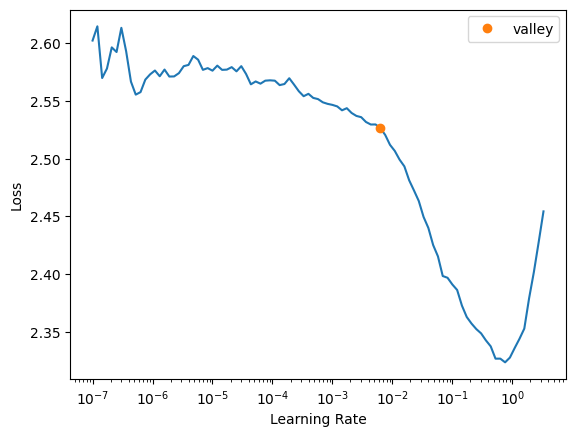

In [112]:
learn2.lr_find()

The valley (0.01) is pretty conservative so Jeremy recommends picking a learning rate further down the curve (0.1) which seems more reasonable. Look for a learning rate that's as far to the right as possible but on a still pretty steep gradient.

In [114]:
learn2.fine_tune(1, 0.1)

epoch,train_loss,valid_loss,dtc_error,time
0,1.070556,1.182892,0.401249,00:47


epoch,train_loss,valid_loss,dtc_error,time
0,1.211720,0.858449,0.259491,00:54


In my [next blog post](https://vishalbakshi.github.io/blog/posts/2024-02-05-paddy-part-6/) I walk through the discussion and code from Live Coding 13, the last Live Coding video on the Paddy Doctor Kaggle competition.